# Chinese characters generator 

In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2DTranspose, Conv2D

from keras.optimizers import SGD, RMSprop

Using TensorFlow backend.


## Data

In [3]:
filename = "./data/vector300_2hier64x64_19_01_18_00_01_35.txt"

X_vec = []
Y_img = []

img_size = 64
wcount = 0
for line in open(filename):
    vec, img = line[:-1].split(",")
    
    vec = np.array([float(n) for n in vec.split(" ")])
    img = np.array([float(n) / 255 - 127 for n in img.split(" ")])
        
    img = np.reshape(img, (img_size, img_size, 1))
    
    X_vec.append(vec)
    Y_img.append(img)
    
    wcount += 1
    if (wcount % 10000 == 0):
        print("{} words processed".format(wcount))
    if wcount > 100000:
        break
        
print("{} words processed".format(wcount))

Y_img = np.array(Y_img)
X_vec = np.array(X_vec)

10000 words processed
20000 words processed
30000 words processed
40000 words processed
50000 words processed
60000 words processed
70000 words processed
80000 words processed
90000 words processed
100000 words processed
100001 words processed


In [4]:
Y_img.shape

(100001, 64, 64, 1)

## Visualisation

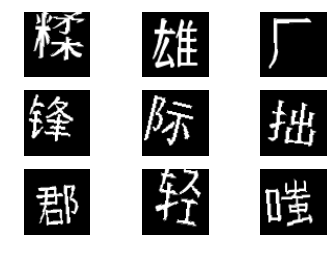

In [5]:
images = Y_img[np.random.randint(0, Y_img.shape[0], 
                                 size=9)]

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i].reshape(img_size, img_size), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

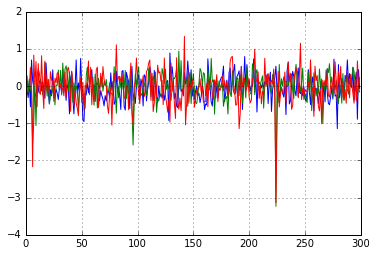

In [6]:
vectors = X_vec[np.random.randint(0, X_vec.shape[0], 
                                  size=3)]

for i in range(3):
    plt.plot(vectors[i])
    
plt.grid()
plt.show()

# GAN
## Generator

In [30]:
gen_dropout = 0.3
gen_input_dim = 8
gen_depth = 512
gen_noise_dim = 300

In [31]:
gennet = Sequential()

# Input 
# fully-connected layer
gennet.add(Dense(gen_input_dim * gen_input_dim * gen_depth, 
                 input_dim=gen_noise_dim))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))
gennet.add(Reshape((gen_input_dim, gen_input_dim, gen_depth)))
gennet.add(Dropout(gen_dropout))

# Deconvolution layers
gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 2), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

# gennet.add(Conv2DTranspose(int(gen_depth / 2), 5, padding='same'))
# gennet.add(BatchNormalization(momentum=0.9))
# gennet.add(Activation('relu'))


gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 4), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

gennet.add(Conv2DTranspose(int(gen_depth / 4), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))


gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 8), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

gennet.add(Conv2DTranspose(int(gen_depth / 8), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))


gennet.add(Conv2DTranspose(int(gen_depth / 16), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

# Output
gennet.add(Conv2DTranspose(1, 5, padding='same'))
gennet.add(Activation('tanh'))

gennet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32768)             9863168   
_________________________________________________________________
batch_normalization_18 (Batc (None, 32768)             131072    
_________________________________________________________________
activation_39 (Activation)   (None, 32768)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 512)         0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 8, 8, 512)         0         
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 16, 16, 256)       3277056   
__________

## Discriminator

In [32]:
disc_depth = 64
disc_dropout = 0.3

discnet = Sequential()

# Input
discnet.add(Conv2D(disc_depth, 5, strides=2, input_shape=(64, 64, 1), 
                   padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*2, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*4, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*8, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*16, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

# Out: scalar estimation of probability
discnet.add(Flatten())
discnet.add(Dense(1))
discnet.add(Activation('sigmoid'))

discnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
activation_47 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
activation_48 (Activation)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 256)         819456    
__________

## Discriminator model

In [33]:
discmodel = Sequential()
discmodel.add(discnet)
discmodel.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0002, clipvalue=1.0, decay=6e-8),
                  metrics=['accuracy'])

## Adversarial model

In [34]:
advmodel = Sequential()
advmodel.add(gennet)
advmodel.add(discnet)
advmodel.compile(loss='binary_crossentropy', 
                 optimizer=RMSprop(lr=0.0001, clipvalue=1.0, decay=3e-8),
                 metrics=['accuracy'])

## Training

In [35]:
batch_size = 128
train_iters = 2000

disc_losses = {"loss": [], "acc": []}
adv_losses = {"loss": [], "acc": []}
log_i = 0

start_time = time.time()

for i in range(train_iters):
    # Get random real images
    images_true = Y_img[np.random.randint(0, 
                                          Y_img.shape[0], 
                                          size=batch_size)]
    # Generate images from noise
    noise = np.random.uniform(-1.0, 1.0, 
                              size=[batch_size, gen_noise_dim])
    images_fake = gennet.predict(noise)
    # Compose training data for discriminator
    x = np.concatenate((images_true, images_fake))
    y = np.concatenate((np.ones((batch_size, 1)), 
                        np.zeros((batch_size, 1))))
    # Train discriminator on composed data
    dics_loss = discmodel.train_on_batch(x, y)
    disc_losses["loss"].append(dics_loss[0])
    disc_losses["acc"].append(dics_loss[1])
    
    # Compose trainig data for adversarial net
    noise = np.random.uniform(-1.0, 1.0, 
                              size=[batch_size, gen_noise_dim])
    y = np.ones([batch_size, 1])
    # Train adversarial net on composed data
    adv_loss = advmodel.train_on_batch(noise, y)
    adv_losses["loss"].append(adv_loss[0])
    adv_losses["acc"].append(adv_loss[1])
    
    # Print results
    if i % 50 == 0:
        curr_time = time.time()
        time_est = (curr_time - start_time) * (train_iters - i + 1) / (i + 1)
        time_est_str = str(timedelta(seconds=time_est)).split('.')[0]
        print("{:4d}th batch of {:4d}|".format(i, train_iters) + \
              "Disc loss {:.3f} |Disc acc {:.3f} |Adv loss {:.3f} |Adv acc {:.3}|".format(dics_loss[0], 
                                                                                          dics_loss[1], 
                                                                                          adv_loss[0], 
                                                                                          adv_loss[1]) +\
              "Time est {}".format(time_est_str))

   0th batch of 2000|Disc loss 0.692 |Disc acc 0.453 |Adv loss 0.022 |Adv acc 1.0|Time est 1:57:27
  10th batch of 2000|Disc loss 0.341 |Disc acc 1.000 |Adv loss 0.000 |Adv acc 1.0|Time est 0:32:53
  20th batch of 2000|Disc loss 0.001 |Disc acc 1.000 |Adv loss 0.000 |Adv acc 1.0|Time est 0:28:34
  30th batch of 2000|Disc loss 0.000 |Disc acc 1.000 |Adv loss 0.000 |Adv acc 1.0|Time est 0:26:57
  40th batch of 2000|Disc loss 0.000 |Disc acc 1.000 |Adv loss 0.000 |Adv acc 1.0|Time est 0:26:10
  50th batch of 2000|Disc loss 0.000 |Disc acc 1.000 |Adv loss 0.000 |Adv acc 1.0|Time est 0:25:39
  60th batch of 2000|Disc loss 0.000 |Disc acc 1.000 |Adv loss 0.000 |Adv acc 1.0|Time est 0:25:16
  70th batch of 2000|Disc loss 0.003 |Disc acc 1.000 |Adv loss 16.118 |Adv acc 0.0|Time est 0:24:57
  80th batch of 2000|Disc loss 0.000 |Disc acc 1.000 |Adv loss 0.000 |Adv acc 1.0|Time est 0:24:45
  90th batch of 2000|Disc loss 0.009 |Disc acc 1.000 |Adv loss 0.067 |Adv acc 1.0|Time est 0:24:33
 100th ba

 820th batch of 2000|Disc loss 0.443 |Disc acc 0.758 |Adv loss 0.910 |Adv acc 0.18|Time est 0:14:55
 830th batch of 2000|Disc loss 0.434 |Disc acc 0.695 |Adv loss 1.984 |Adv acc 0.0|Time est 0:14:48
 840th batch of 2000|Disc loss 0.928 |Disc acc 0.508 |Adv loss 1.114 |Adv acc 0.0469|Time est 0:14:40
 850th batch of 2000|Disc loss 0.480 |Disc acc 0.629 |Adv loss 1.574 |Adv acc 0.0|Time est 0:14:33
 860th batch of 2000|Disc loss 0.692 |Disc acc 0.598 |Adv loss 1.167 |Adv acc 0.0156|Time est 0:14:25
 870th batch of 2000|Disc loss 0.719 |Disc acc 0.582 |Adv loss 1.067 |Adv acc 0.0391|Time est 0:14:17
 880th batch of 2000|Disc loss 0.518 |Disc acc 0.824 |Adv loss 0.827 |Adv acc 0.266|Time est 0:14:10
 890th batch of 2000|Disc loss 0.605 |Disc acc 0.621 |Adv loss 1.547 |Adv acc 0.0|Time est 0:14:02
 900th batch of 2000|Disc loss 0.578 |Disc acc 0.609 |Adv loss 3.237 |Adv acc 0.0|Time est 0:13:55
 910th batch of 2000|Disc loss 0.398 |Disc acc 0.879 |Adv loss 1.164 |Adv acc 0.00781|Time est 0:

1640th batch of 2000|Disc loss 0.606 |Disc acc 0.742 |Adv loss 0.754 |Adv acc 0.367|Time est 0:04:33
1650th batch of 2000|Disc loss 0.679 |Disc acc 0.527 |Adv loss 1.372 |Adv acc 0.0547|Time est 0:04:25
1660th batch of 2000|Disc loss 0.545 |Disc acc 0.754 |Adv loss 1.021 |Adv acc 0.117|Time est 0:04:18
1670th batch of 2000|Disc loss 0.663 |Disc acc 0.566 |Adv loss 1.113 |Adv acc 0.0703|Time est 0:04:10
1680th batch of 2000|Disc loss 0.937 |Disc acc 0.512 |Adv loss 2.523 |Adv acc 0.0|Time est 0:04:03
1690th batch of 2000|Disc loss 0.607 |Disc acc 0.582 |Adv loss 0.940 |Adv acc 0.133|Time est 0:03:55
1700th batch of 2000|Disc loss 0.537 |Disc acc 0.789 |Adv loss 0.983 |Adv acc 0.148|Time est 0:03:47
1710th batch of 2000|Disc loss 1.336 |Disc acc 0.500 |Adv loss 2.324 |Adv acc 0.0|Time est 0:03:40
1720th batch of 2000|Disc loss 0.902 |Disc acc 0.504 |Adv loss 2.150 |Adv acc 0.0|Time est 0:03:32
1730th batch of 2000|Disc loss 0.701 |Disc acc 0.547 |Adv loss 0.974 |Adv acc 0.188|Time est 0:

## Discriminator losses

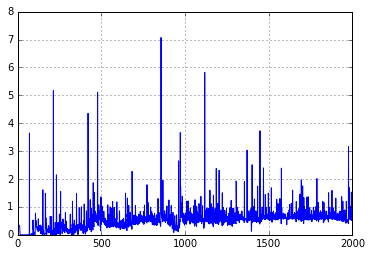

In [36]:
plt.plot(disc_losses["loss"])
plt.grid()

## Adversarial net losses

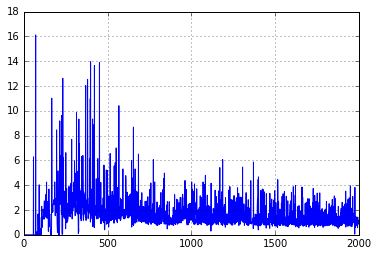

In [37]:
plt.plot(adv_losses["loss"])
plt.grid()

## An attempt to generate images

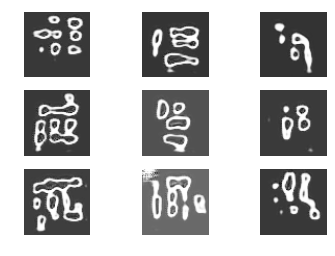

In [38]:
noise = np.random.uniform(-1.0, 1.0, size=[10, gen_noise_dim])
fake_images = gennet.predict(noise)

    
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(fake_images[i].reshape(64, 64), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()